# Comment Toxicity Model

## Setup

Data available at https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras

In [17]:
data = pd.read_csv("./data/train.csv")

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Data preprocessing

In [18]:
X = data['comment_text']
y = data.iloc[:,2:].values

### Adding a text vectorizer layer

In [19]:
MAX_FEATURES = 200000 # Number of words in the vocabulary

In [20]:
vectorizer = keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode="int"
)

In [21]:
vectorizer.adapt(X.values)

In [22]:
# Look at the first 10 words in the vocabulary
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'you', 'i', 'is']

In [23]:
vectorizer('Hello world!')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263,   0, ...,   0,   0,   0])>

In [24]:
vectorized_text = vectorizer(X.values)

In [25]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

### Create dataset

In [26]:
# MCSHBAP
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8)

In [27]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

batch_x.shape, batch_y.shape

((16, 1800), (16, 6))

In [28]:
train = dataset.take(int(len(dataset) * 0.7))
val = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

In [29]:
len(train), len(val), len(test)

(6981, 1994, 997)

In [30]:
train_generator = train.as_numpy_iterator()

In [31]:
train_generator.next()

(array([[  198,  1144,    22, ...,     0,     0,     0],
        [  110, 88062,  4366, ...,     0,     0,     0],
        [    8,    88,     6, ...,     0,     0,     0],
        ...,
        [  124,   542,    13, ...,     0,     0,     0],
        [   76,    55,     7, ...,     0,     0,     0],
        [   49,   616,   436, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]]))

## Creating Sequential Model

In [32]:
from keras import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Embedding

In [33]:
model = Sequential()
#Creating the embedding layer, we are adding 1 because we want to reserve the 0 index
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layers
model.add(Dense(128,activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128,activation='relu'))
#Final layer
model.add(Dense(6, activation='sigmoid'))

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [36]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 1678s 240ms/step - loss: 0.0627 - val_loss: 0.0478


## Making Predictions


1/1 [==============================] - 0s 38ms/step


<BarContainer object of 6 artists>

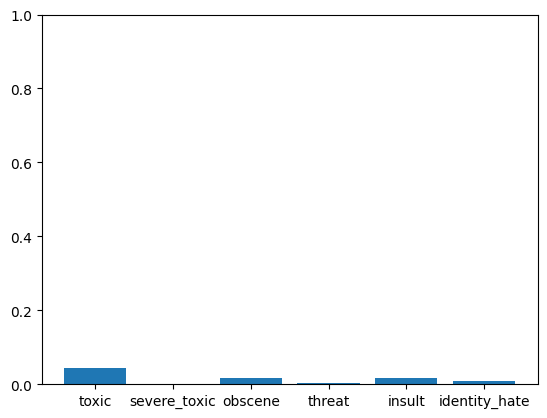

In [124]:
input_text= vectorizer('i love you ')
result = model.predict(np.array([input_text]))
result

#print last 6 column names of data
data.columns[-6:]
head=np.array([data.columns[-6:]])

#plotting head vs result with y scale 0-1
plt.ylim(0,1)
plt.bar(head[0],result[0])

## Evaluating model

In [71]:
from keras.metrics import Precision, Recall, CategoricalAccuracy

In [125]:
pre = Precision()
re = Recall() 
acc = CategoricalAccuracy()

In [127]:
for batch in test.as_numpy_iterator():
    #unpack the batch
    X_true, y_true = batch

    y_pred = model.predict(X_true)

    #Flatten the predictions
    y_true= y_true.flatten()
    y_pred=y_pred.flatten()


    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    acc.update_state(y_true, y_pred)

1/1 [==============================] - 0s 40ms/step


In [128]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7731861472129822, Recall: 0.7162477970123291, Accuracy: 0.46840521693229675


## Test and Gradio

In [135]:
import gradio as gr

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (/opt/homebrew/lib/python3.11/site-packages/typing_extensions.py)

In [136]:
model.save('toxicity.h5')
#model = tf.kreas.models.load_model('toxicity.h5')  #to import model directly





/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [156]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text=''
    for idx, col in enumerate(data.columns[2:-1]):
        text += f'{col}: {results[0][idx]>0.5}|| '
    return text

In [159]:
interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'), outputs="text")

NameError: name 'gr' is not defined

In [ ]:
interface.launch(share=True)